## CatBoostRegressor
- userid, bookid 라벨인코딩
- year_of_publication 범주화하기

In [3]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 20.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 46.8 MB/s eta 0:00:0000:0100:01


In [4]:
import numpy as np
import pandas as pd
import time
import argparse
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import os
import tqdm
from torch.nn import MSELoss
from torch.optim import SGD, Adam

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostRegressor


In [5]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
submit = pd.read_csv('./sample_submission.csv')

In [6]:
train_df.head()

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871393 entries, 0 to 871392
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   871393 non-null  object 
 1   User-ID              871393 non-null  object 
 2   Book-ID              871393 non-null  object 
 3   Book-Rating          871393 non-null  int64  
 4   Age                  871393 non-null  float64
 5   Location             871393 non-null  object 
 6   Book-Title           871393 non-null  object 
 7   Book-Author          871393 non-null  object 
 8   Year-Of-Publication  871393 non-null  float64
 9   Publisher            871393 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 66.5+ MB


#### Age 분포 확인하기

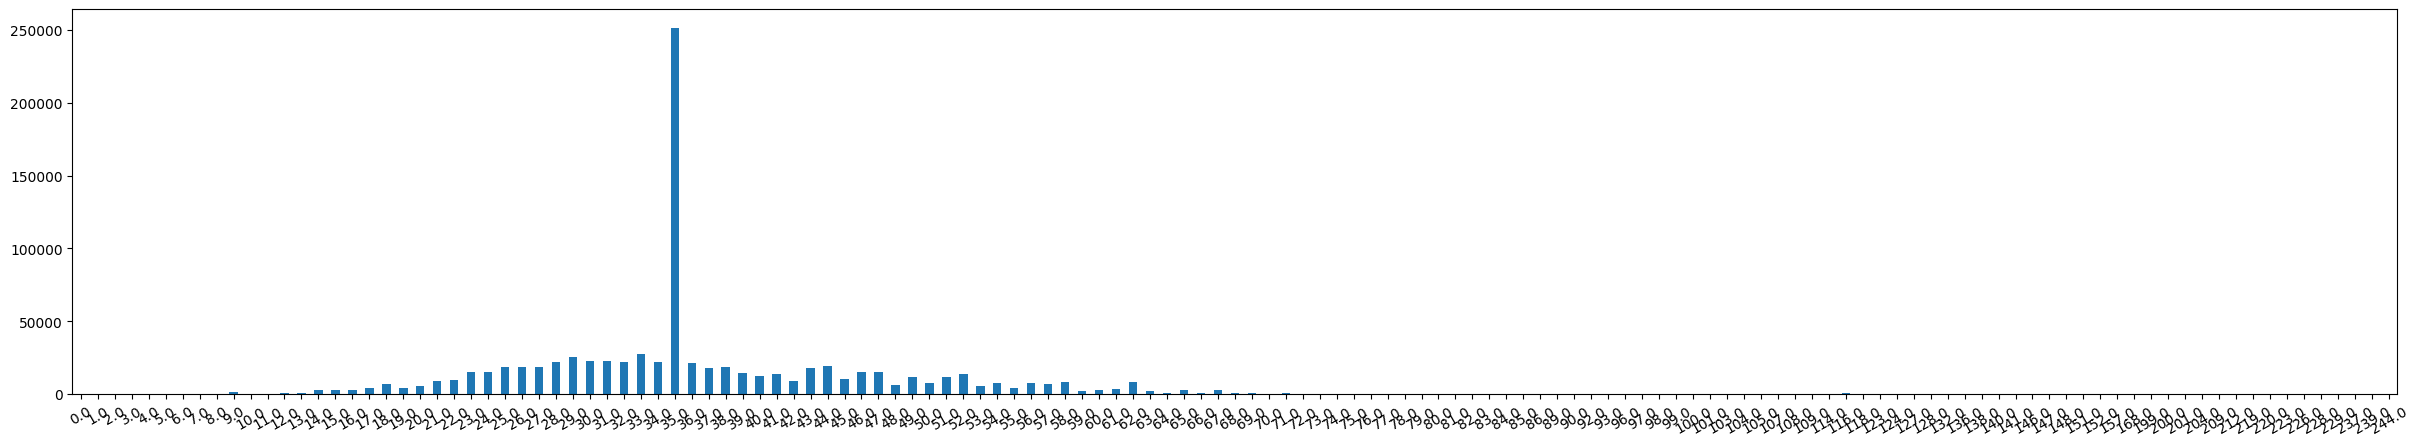

In [8]:
plt.figure(figsize=(30,5))
train_df['Age'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=30) 
plt.show()

In [9]:
train_df['Age'].value_counts()


35.0     251455
33.0      27349
29.0      25456
30.0      23085
31.0      22515
          ...  
118.0         1
109.0         1
147.0         1
123.0         1
132.0         1
Name: Age, Length: 137, dtype: int64

#### Year_Of_Publication 분포 확인하기

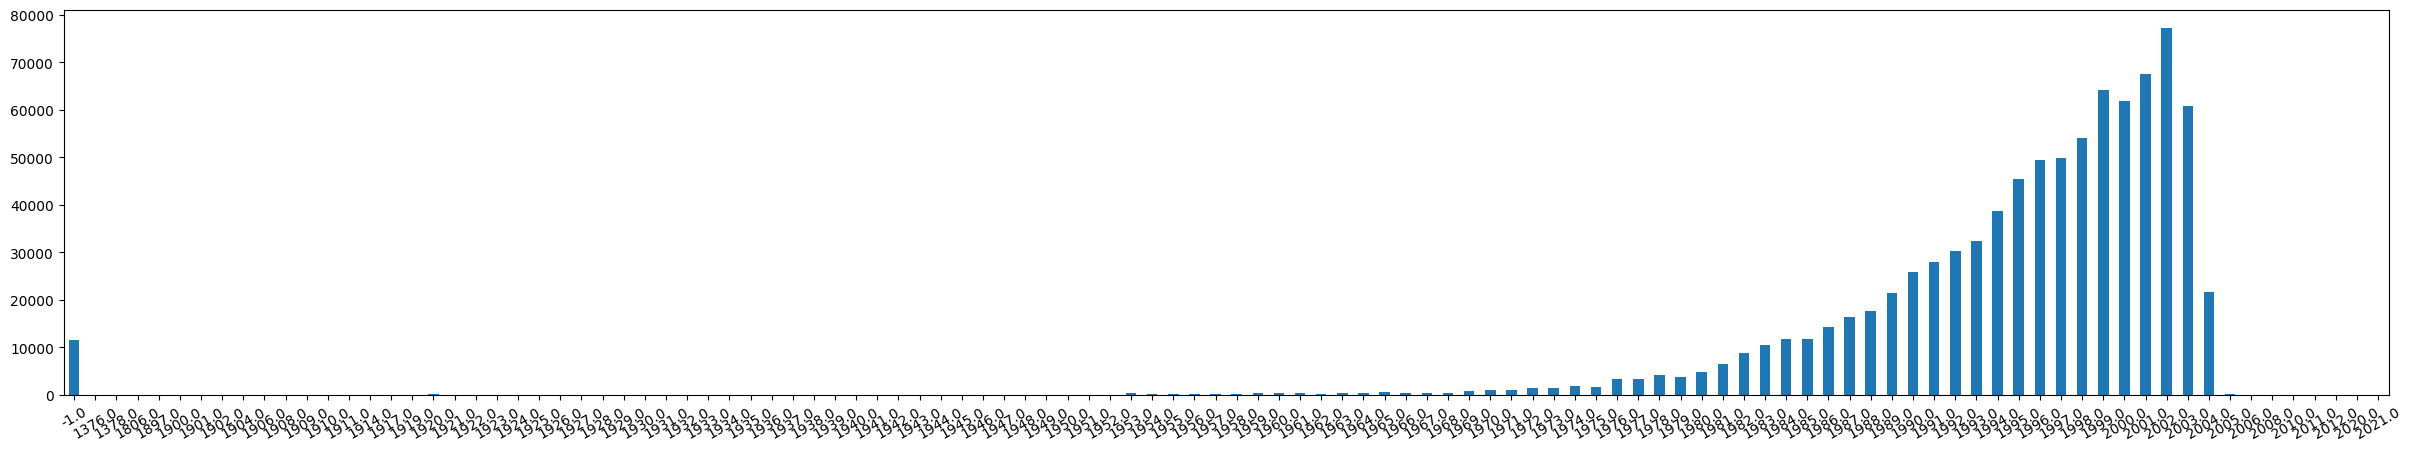

In [10]:
plt.figure(figsize=(30,5))
train_df['Year-Of-Publication'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=30) 
plt.show()

In [11]:
train_df['Year-Of-Publication'].max()

2021.0

In [12]:
train_df['Year-Of-Publication'].value_counts()


2002.0    77173
2001.0    67566
1999.0    64175
2000.0    61749
2003.0    60744
          ...  
2008.0        1
1909.0        1
1904.0        1
1378.0        1
1910.0        1
Name: Year-Of-Publication, Length: 110, dtype: int64

In [13]:
def year_map(x: int) -> int:
    x = int(x)
    if x < 0:
        return 0
    elif x < 1980:
        return 1
    elif x < 1990:
        return 2
    elif x < 1995:
        return 3
    elif x < 2000:
        return 4
    elif x < 2005:
        return 5
    else:
        return 6
train_df['Year-Of-Publication'] = train_df['Year-Of-Publication'].apply(year_map)
test_df['Year-Of-Publication'] = test_df['Year-Of-Publication'].apply(year_map)

In [34]:
test_df.shape

(159621, 9)

In [35]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159621 entries, 0 to 159620
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   159621 non-null  object
 1   User-ID              159621 non-null  object
 2   Book-ID              159621 non-null  object
 3   Age                  159621 non-null  int64 
 4   Location             159621 non-null  object
 5   Book-Title           159621 non-null  object
 6   Book-Author          159621 non-null  object
 7   Year-Of-Publication  159621 non-null  int64 
 8   Publisher            159621 non-null  object
dtypes: int64(2), object(7)
memory usage: 11.0+ MB


### Location column 분리

In [14]:
# Location 전처리해서 3개의 column으로 나누기
train_df['Location_city'] = train_df['Location'].apply(lambda x: x.split(',')[0].strip())
train_df['Location_state'] = train_df['Location'].apply(lambda x: x.split(',')[1].strip())
train_df['Location_country'] = train_df['Location'].apply(lambda x: x.split(',')[2].strip())
train_df = train_df.drop(['Location'], axis=1)

test_df['Location_city'] = test_df['Location'].apply(lambda x: x.split(',')[0].strip())
test_df['Location_state'] = test_df['Location'].apply(lambda x: x.split(',')[1].strip())
test_df['Location_country'] = test_df['Location'].apply(lambda x: x.split(',')[2].strip())
test_df = test_df.drop(['Location'], axis=1)

train_df.head()

,ID,User-ID,Book-ID,Book-Rating,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location_city,Location_state,Location_country
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,Road Taken,Rona Jaffe,5,Mira,sackville,new brunswick,canada
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,Macbeth (New Penguin Shakespeare),William Shakespeare,2,Penguin Books,sackville,new brunswick,canada
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,Waverley (Penguin English Library),Walter Scott,2,Penguin Books,sackville,new brunswick,canada
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,Mother Earth Father Sky,Sue Harrison,3,Avon,sackville,new brunswick,canada
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,She Who Remembers,Linda Lay Shuler,2,Signet Book,sackville,new brunswick,canada


In [15]:
# 빈 문자열, n/a문자 => 결측치로 변경
train_df = train_df.replace('', np.nan)
train_df = train_df.replace('n/a', np.nan)

test_df = test_df.replace('', np.nan)
test_df = test_df.replace('n/a', np.nan)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871393 entries, 0 to 871392
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   871393 non-null  object 
 1   User-ID              871393 non-null  object 
 2   Book-ID              871393 non-null  object 
 3   Book-Rating          871393 non-null  int64  
 4   Age                  871393 non-null  float64
 5   Book-Title           871393 non-null  object 
 6   Book-Author          871393 non-null  object 
 7   Year-Of-Publication  871393 non-null  int64  
 8   Publisher            871393 non-null  object 
 9   Location_city        857421 non-null  object 
 10  Location_state       834408 non-null  object 
 11  Location_country     839069 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 79.8+ MB


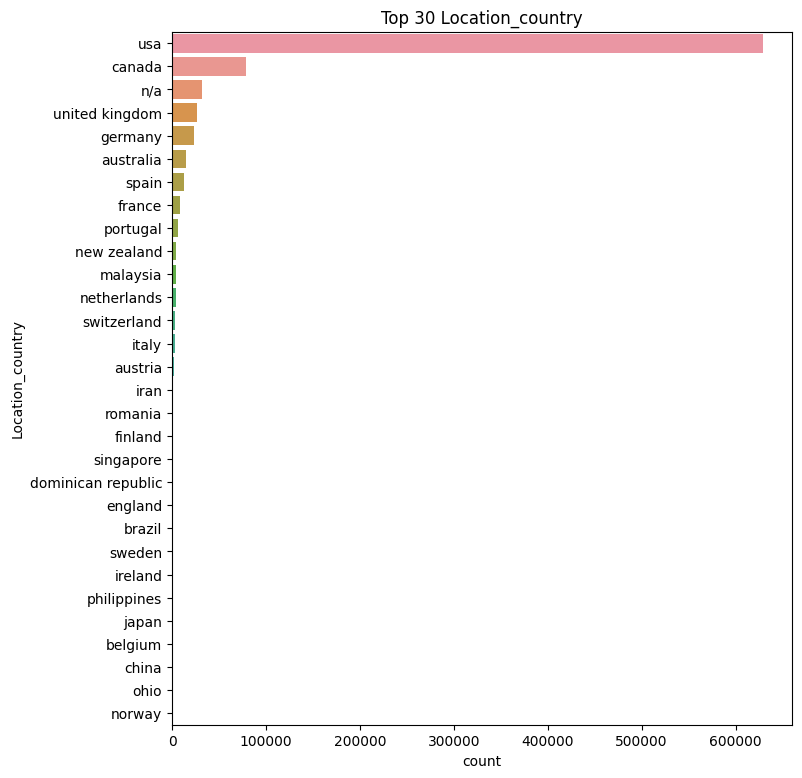

In [ ]:
ds = train_df['Location_country'].value_counts().reset_index()
ds.columns = ['Location_country', 'count']
ds = ds.sort_values('count', ascending=False).head(30)

plt.figure(figsize=(8, 9))
sns.barplot(data=ds, x='count', y='Location_country')
plt.title('Top 30 Location_country')
plt.xlabel('count')
plt.ylabel('Location_country')
plt.show()

In [29]:
df_copy = train_df.copy()
df_copy

,ID,User-ID,Book-ID,Book-Rating,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location_city,Location_state,Location_country
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,Road Taken,Rona Jaffe,5,Mira,sackville,new brunswick,canada
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,Macbeth (New Penguin Shakespeare),William Shakespeare,2,Penguin Books,sackville,new brunswick,canada
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,Waverley (Penguin English Library),Walter Scott,2,Penguin Books,sackville,new brunswick,canada
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,Mother Earth Father Sky,Sue Harrison,3,Avon,sackville,new brunswick,canada
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,She Who Remembers,Linda Lay Shuler,2,Signet Book,sackville,new brunswick,canada
...,...,...,...,...,...,...,...,...,...,...,...,...
871388,TRAIN_871388,USER_92096,BOOK_081138,0,34.0,Healing Words: The Power of Prayer and the Pra...,Larry Dossey,3,Harpercollins,minneapolis,minnesota,usa
871389,TRAIN_871389,USER_92097,BOOK_258124,0,35.0,The Salmon of Doubt: Hitchhiking the Galaxy On...,DOUGLAS ADAMS,5,Harmony,temple,texas,usa
871390,TRAIN_871390,USER_92098,BOOK_071848,0,45.0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,5,Thorndike Press,ottawa,ontario,canada
871391,TRAIN_871391,USER_92099,BOOK_252599,8,43.0,Heartbreak Hill: Anatomy of a Ryder Cup,Tim Rosaforte,4,St Martins Pr,maple grove,minnesota,usa


### 결측치 채우기
- Location_state 또는 Location_country가 결측치일 경우, Location_city가 같은 행의 값으로 채우기

In [34]:
from tqdm import tqdm

condition_1 = df_copy['Location_state'].isnull() & df_copy['Location_city'].notnull()
condition_2 = df_copy['Location_country'].isnull() & df_copy['Location_state'].isnull() & df_copy['Location_city'].notnull()

unique_cities = df_copy.loc[(df_copy['Location_state'].notnull()) & (df_copy['Location_country'].notnull()), 'Location_city'].unique()

for city in tqdm(unique_cities):
    matching_rows = (df_copy['Location_city'] == city) & (condition_1 | condition_2)
    
    matching_rows_with_values = (df_copy['Location_city'] == city) & (df_copy['Location_state'].notnull()) & (df_copy['Location_country'].notnull())
    if matching_rows_with_values.any():
        matching_row = df_copy.loc[matching_rows_with_values, ['Location_state', 'Location_country']].iloc[0]
        df_copy.loc[matching_rows, 'Location_state'] = matching_row['Location_state']
        df_copy.loc[matching_rows, 'Location_country'] = matching_row['Location_country']


100%|██████████| 13249/13249 [26:37<00:00,  8.29it/s]


In [39]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871393 entries, 0 to 871392
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   871393 non-null  object 
 1   User-ID              871393 non-null  object 
 2   Book-ID              871393 non-null  object 
 3   Book-Rating          871393 non-null  int64  
 4   Age                  871393 non-null  float64
 5   Book-Title           871393 non-null  object 
 6   Book-Author          871393 non-null  object 
 7   Year-Of-Publication  871393 non-null  int64  
 8   Publisher            871393 non-null  object 
 9   Location_city        857421 non-null  object 
 10  Location_state       856905 non-null  object 
 11  Location_country     853343 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 79.8+ MB


In [40]:
# df_copy.to_csv('./train_df_copy.csv', index=False)

In [41]:
train_df = df_copy.copy()

In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871393 entries, 0 to 871392
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   871393 non-null  object 
 1   User-ID              871393 non-null  object 
 2   Book-ID              871393 non-null  object 
 3   Book-Rating          871393 non-null  int64  
 4   Age                  871393 non-null  float64
 5   Book-Title           871393 non-null  object 
 6   Book-Author          871393 non-null  object 
 7   Year-Of-Publication  871393 non-null  int64  
 8   Publisher            871393 non-null  object 
 9   Location_city        857421 non-null  object 
 10  Location_state       856905 non-null  object 
 11  Location_country     853343 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 79.8+ MB


In [43]:
# 문자 제거
train_df['User-ID'] = train_df['User-ID'].str.split('_').str[-1]
train_df['Book-ID'] = train_df['Book-ID'].str.split('_').str[-1]
test_df['User-ID'] = test_df['User-ID'].str.split('_').str[-1]
test_df['Book-ID'] = test_df['Book-ID'].str.split('_').str[-1]

In [44]:
train_df.head()

,ID,User-ID,Book-ID,Book-Rating,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location_city,Location_state,Location_country
0,TRAIN_000000,00000,044368,8,23.0,Road Taken,Rona Jaffe,5,Mira,sackville,new brunswick,canada
1,TRAIN_000001,00000,081205,8,23.0,Macbeth (New Penguin Shakespeare),William Shakespeare,2,Penguin Books,sackville,new brunswick,canada
2,TRAIN_000002,00000,086781,0,23.0,Waverley (Penguin English Library),Walter Scott,2,Penguin Books,sackville,new brunswick,canada
3,TRAIN_000003,00000,098622,0,23.0,Mother Earth Father Sky,Sue Harrison,3,Avon,sackville,new brunswick,canada
4,TRAIN_000004,00000,180810,8,23.0,She Who Remembers,Linda Lay Shuler,2,Signet Book,sackville,new brunswick,canada


In [45]:
train_x = train_df.drop(['ID', 'Book-Rating'], axis=1)
train_y = train_df['Book-Rating']
test_x = test_df.drop(['ID'], axis=1)

train_x.head()

,User-ID,Book-ID,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location_city,Location_state,Location_country
0,00000,044368,23.0,Road Taken,Rona Jaffe,5,Mira,sackville,new brunswick,canada
1,00000,081205,23.0,Macbeth (New Penguin Shakespeare),William Shakespeare,2,Penguin Books,sackville,new brunswick,canada
2,00000,086781,23.0,Waverley (Penguin English Library),Walter Scott,2,Penguin Books,sackville,new brunswick,canada
3,00000,098622,23.0,Mother Earth Father Sky,Sue Harrison,3,Avon,sackville,new brunswick,canada
4,00000,180810,23.0,She Who Remembers,Linda Lay Shuler,2,Signet Book,sackville,new brunswick,canada


In [48]:
train_x.loc[train_x['Location_city'].isna()]

,User-ID,Book-ID,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location_city,Location_state,Location_country
3461,00543,029594,35.0,The Inheritance,Tom Savage,4,Signet Book,NaN,maine,usa
13125,01536,069712,50.0,The Assassin: A Story of Race and Rage in the ...,Henk Van Woerden,5,Metropolitan Books,NaN,western australia,australia
28764,03185,011227,35.0,A Gift of Hope: How We Survive Our Tragedies,Robert L. Veninga,4,Ballantine Books,NaN,NaN,usa
28765,03185,073202,35.0,The Heart Reader,Anonymous,5,WestBow Press,NaN,NaN,usa
28766,03185,105895,35.0,The Divine Secrets of the Ya-Ya Sisterhood: A ...,Rebecca Wells,5,HarperTorch,NaN,NaN,usa
...,...,...,...,...,...,...,...,...,...,...
839370,88318,180594,54.0,Restless Pilgrim: The Spiritual Journey of Bob...,Scott Marshall,5,Relevant Books,NaN,florida,usa
839371,88318,242263,54.0,Meditations for Misfits: Finding Your Place in...,Marcia Ford,5,Jossey-Bass,NaN,florida,usa
867619,91714,129896,35.0,"Martha Quest (Her Children of violence, v. 1)",Doris May Lessing,1,Panther,NaN,shetland,united kingdom
869549,91819,217149,47.0,Immortality,Milan Kundera,0,Faber Faber Inc,NaN,NaN,portugal


In [49]:
# 결측치 대체
train_x = train_x.fillna("NaN")
test_x = test_x.fillna("NaN")

In [50]:
seed = 42
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=seed)

### CatBoostRegressor + Stratifed 10K Fold
- age, year_of_publication을 cat_feature에 포함X

In [51]:
skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

result_list = []
n = 0

for train_index, valid_index in skf.split(train_x, train_y):
    print("============== " + str(n) + "th ==============")
    train_X = np.array(train_x)
    train_Y = np.array(train_y)
    
    X_train, X_valid = train_X[train_index], train_X[valid_index]
    y_train, y_valid = train_Y[train_index], train_Y[valid_index]

    model = CatBoostRegressor(cat_features=[0, 1, 3, 4, 6, 7, 8, 9], 
                            task_type='GPU',
                            random_seed = seed,
                            iterations=3500, 
                            learning_rate=0.1,
                            max_depth=6,
                            verbose=1000)

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    pred = model.predict(test_x)
    pred[np.where(pred < 0)] = 0
    pred[np.where(pred > 10)] = 10
    result_list.append(pred)
    
    n += 1

============== 0th ==============
0:	learn: 3.7794596	test: 3.7734450	best: 3.7734450 (0)	total: 23.9ms	remaining: 1m 23s
1000:	learn: 3.2947517	test: 3.2564984	best: 3.2564978 (997)	total: 24.1s	remaining: 1m
2000:	learn: 3.2745410	test: 3.2539891	best: 3.2539891 (2000)	total: 48.2s	remaining: 36.1s
3000:	learn: 3.2573904	test: 3.2526043	best: 3.2525064 (2857)	total: 1m 12s	remaining: 12.1s
3499:	learn: 3.2495623	test: 3.2522706	best: 3.2521920 (3470)	total: 1m 25s	remaining: 0us
bestTest = 3.252192019
bestIteration = 3470
Shrink model to first 3471 iterations.
============== 1th ==============
0:	learn: 3.7795993	test: 3.7746795	best: 3.7746795 (0)	total: 23.7ms	remaining: 1m 23s
1000:	learn: 3.2955562	test: 3.2527064	best: 3.2527064 (1000)	total: 24.9s	remaining: 1m 2s
2000:	learn: 3.2747949	test: 3.2495662	best: 3.2495662 (2000)	total: 50.1s	remaining: 37.5s
3000:	learn: 3.2581387	test: 3.2487181	best: 3.2485961 (2723)	total: 1m 14s	remaining: 12.5s
3499:	learn: 3.2502429	test: 3.2

In [52]:
result_list

[array([6.06541099, 6.89511471, 6.75901212, ..., 4.4388473 , 3.20309491,
        3.86665918]),
 array([5.80176416, 6.66824989, 6.445574  , ..., 4.39280414, 4.23190165,
        5.19127254]),
 array([5.68902573, 6.61178577, 6.54019154, ..., 4.61445601, 3.62502542,
        4.46121241]),
 array([5.39354545, 6.28184557, 6.1093154 , ..., 4.82275382, 3.16713307,
        4.5939252 ]),
 array([5.25953203, 6.02764904, 6.36962052, ..., 3.73575779, 4.11856366,
        4.65122092]),
 array([6.05624901, 6.99807029, 7.13881909, ..., 3.71850582, 3.00302481,
        4.39243262]),
 array([5.27670472, 5.93656056, 6.06514815, ..., 4.25099593, 3.72731802,
        5.00600661]),
 array([5.54004768, 6.3448151 , 6.21102429, ..., 4.4850591 , 3.5839701 ,
        5.22540396]),
 array([5.277447  , 6.4548185 , 5.81981977, ..., 4.84899718, 3.3060032 ,
        3.68827215]),
 array([5.09843767, 6.27123707, 6.1070359 , ..., 4.81182449, 3.81681577,
        4.62794307])]

In [53]:
result = np.array(result_list[0])

for i in range(1, len(result_list)):
    result += result_list[i]
    
result /= 10
result

array([5.54581645, 6.44901465, 6.35655608, ..., 4.41200016, 3.57828506,
       4.57043487])

#### Result

In [54]:
submit['Book-Rating'] = result
submit.tail(50)

,ID,Book-Rating
159571,TEST_159571,1.963085
159572,TEST_159572,5.324560
159573,TEST_159573,4.202930
159574,TEST_159574,5.287199
159575,TEST_159575,5.712250
159576,TEST_159576,5.837592
159577,TEST_159577,5.111499
159578,TEST_159578,6.168941
159579,TEST_159579,6.541226
159580,TEST_159580,6.288506


In [55]:
submit.to_csv('/notebooks/result/cat_loc_age_10skf_year_1_pre_na_2.csv', index=False)

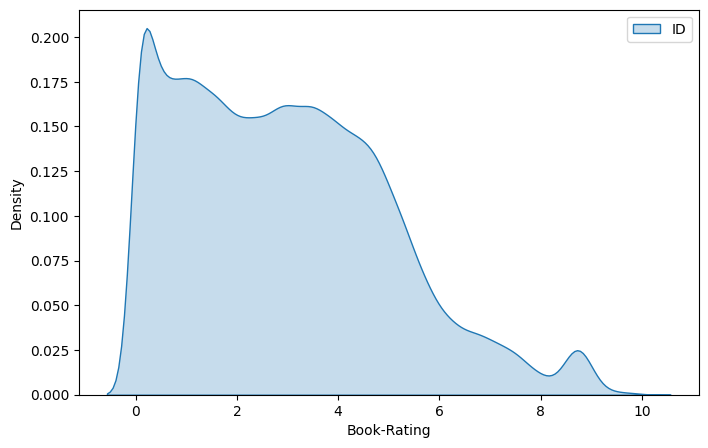

In [56]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(x='Book-Rating', data=submit, fill=True)
plt.legend(labels=submit)
plt.show()

Text(0.5, 1.0, 'Feature Importance')

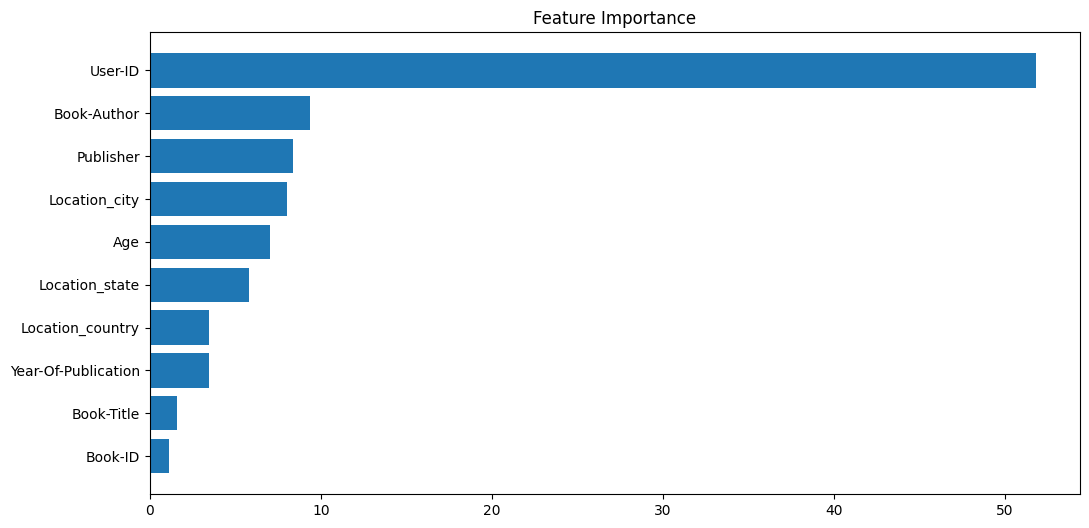

In [57]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_x.columns)[sorted_idx])
plt.title('Feature Importance')